# Problem 1
Perform sentimental analysis on the Elon-musk tweets (Elon-musk.csv)

## Import Necessary libraries:

In [1]:
import pandas as pd
import numpy as np

import re
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from matplotlib import pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

#import matplotlib.pylab as plt # try this while uploading to github

## Loading  data and initial analysis.

In [2]:
tweets = pd.read_csv('Elon_musk.csv', names=['tweet_no', 'tweet'])

In [3]:
tweets.head()

,tweet_no,tweet
0,NaN,Text
1,1.0,@kunalb11 I�m an alien
2,2.0,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
3,3.0,@joerogan @Spotify Great interview!
4,4.0,@gtera27 Doge is underestimated


In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_no  1999 non-null   float64
 1   tweet     2000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 31.4+ KB


## Data preprocessing
- Remove unwanted columns.
- Remove special characters, numbers etc.
- Lemmatization (stemming if not using lemmatization)
- Get all positive and negative words from lexicon provided.

In [5]:
tweets.drop(index=tweets.index[0], axis=0, inplace=True)
tweets.drop('tweet_no', axis=1, inplace=True)
tweets.reset_index(drop=True, inplace=True)

In [6]:
tweets.head()

,tweet
0,@kunalb11 I�m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...


In [7]:
# Function to collect words from lexicons (provided as txt files).
def load_lexicon(filename):
    file = open(filename)

    # Throw away lines of the file until just before the data starts
    # In the provided files, the last line before the actual data starts is a blank line
    while file.readline() != '\n': # when it encounters a blank line it will return '\n'.first line in lexicon starts after blank.
        pass

    # Pandas will only process the lines from the current file position onwards
    word_list = np.loadtxt(file, dtype='str')

    # Don't forget to close the file when you're done
    file.close()
    return word_list
    

In [8]:
# Get all the positive, negative and stopwords.
positive_words = load_lexicon('positive-words.txt') 
negative_words = load_lexicon('negative-words.txt')
#stopwords = pd.read_csv('stop.txt').to_numpy().ravel() # Get the list of stopwords from the file provided.

In [9]:
lemmatizer = WordNetLemmatizer() # lemmatization
#ps = PorterStemmer() # uncomment for stemming

corpus = []
for i in range(0, len(tweets)):
    review = re.sub('RT @[\w]*:', ' ', tweets['tweet'][i]) # Remove twitter return handles (RT @xxx:)
    review = re.sub('@[\w]*', ' ', review) # Remove all twitter handles
    review = re.sub('https?://[A-Za-z0-9./]*', ' ', review) # Remove all URL links
    review = re.sub('[^a-zA-Z]', ' ', review)#remove special characters, numbers, punctuations (except for #)
    review = review.lower()
    review = review.split()
    # Note: I have added the lexicon of stopwords provided inside my nltk lexicon folder since I was getting
    # errors while performing the iterations in the next step when I used the txt file.
    review = [lemmatizer.lemmatize(word) for word in review if not word in stopwords.words('english_custom')]
    #review = [ps.stem(word) for word in review if not word in stopwords.words('english_custom')]
    review = ' '.join(review)    
    corpus.append(review)

In [10]:
print(corpus[:10])

['alien', 'ray tracing cyberpunk hdr level', 'great interview', 'doge underestimated', 'congratulation tesla china amazing execution year', 'happy year ox', 'frodo underdoge thought fail', 'haha', 'tweet represent real world time allocation', 'entertaining outcome']


## Visualizing the different words used by Elon Musk to express his sentiments

In [11]:
# Function to visualize the the positive and negative words used by Elon Musk:
def make_word_cloud(corpus, sentiment_words=None, sentiments=True):
    if sentiments == True:
        # Make a list of emotion words.
        para = []
        for i in range(len(corpus)):
            para.extend(corpus[i].split(' '))
        word_list_com = ' '.join([w for w in para if w in sentiment_words])   
    else:
        word_list_com = ' '.join(corpus)
    
    # Make the word cloud.
    wordcloud = WordCloud(max_font_size=50, 
                          background_color='white', 
                          colormap='tab10',
                          random_state=42).generate(word_list_com)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    # Note: Other suitable cmaps: 'gist_earth', 'Dark2', 'viridis', 'jet'

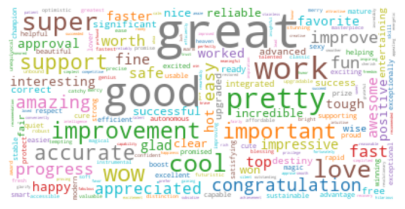

In [12]:
# Wordcloud for positive words.
make_word_cloud(corpus, positive_words)

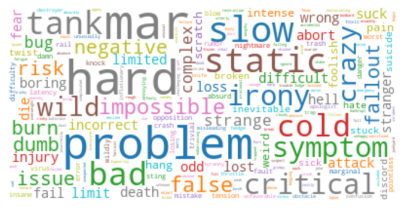

In [13]:
# Wordcloud for negative words.
make_word_cloud(corpus, negative_words)

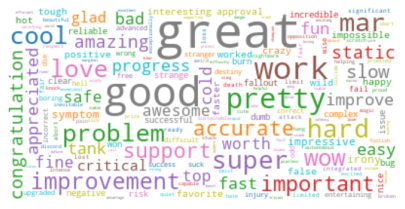

In [14]:
# Wordcloud for all sentiment words used by Elon Musk irrespective of sentiment type.
sentiment_words = np.concatenate((positive_words,negative_words), axis=None) 
make_word_cloud(corpus,sentiment_words)

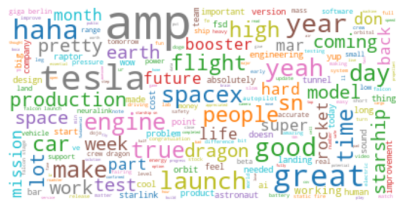

In [15]:
# Wordcloud for all words used by Elon Musk irrespective of sentiment type.
make_word_cloud(corpus,sentiments=False)

## Using VADER for sentiment analysis
Ref: https://python.plainenglish.io/twitter-sentiment-analysis-using-vader-tweepy-b2a62fba151e

In [16]:
tweets_prc = pd.DataFrame(corpus,columns = ['tweet'],index=tweets.index)

In [17]:
tweets_prc.head()

,tweet
0,alien
1,ray tracing cyberpunk hdr level
2,great interview
3,doge underestimated
4,congratulation tesla china amazing execution year


In [18]:
# !pip install vaderSentiment

In [19]:
analyzer = SentimentIntensityAnalyzer()

In [20]:
scores = []# Declare variables for scores
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
for i in range(tweets_prc['tweet'].shape[0]):#print(analyser.polarity_scores(sentiments_pd['text'][i]))
    compound = analyzer.polarity_scores(tweets_prc['tweet'][i])["compound"]
    pos = analyzer.polarity_scores(tweets_prc['tweet'][i])["pos"]
    neu = analyzer.polarity_scores(tweets_prc['tweet'][i])["neu"]
    neg = analyzer.polarity_scores(tweets_prc['tweet'][i])["neg"]
    
    scores.append({"Compound": compound,
                       "Positive": pos,
                       "Negative": neg,
                       "Neutral": neu
                  })

In [21]:
# Convert the scores dictionary to dataframe, join it to tweets_prc2 dataframe.
sentiments_score = pd.DataFrame.from_dict(scores)
tweets_prc = tweets_prc.join(sentiments_score)
tweets_prc.head()

,tweet,Compound,Positive,Negative,Neutral
0,alien,0.0000,0.000,0.000,1.000
1,ray tracing cyberpunk hdr level,0.0000,0.000,0.000,1.000
2,great interview,0.6249,0.804,0.000,0.196
3,doge underestimated,-0.2732,0.000,0.677,0.323
4,congratulation tesla china amazing execution year,0.8271,0.658,0.000,0.342


In [22]:
# Classify the tweet as positive, negative or neutral based on the compound score.
# Ref: https://akladyous.medium.com/sentiment-analysis-using-vader-c56bcffe6f24
def polarity_score(compound):
    if compound > 0.05:
        return "positive"
    elif compound < -0.05:
        return "negative"
    elif compound >= -0.05 and compound < 0.05:
        return "neutral"

In [23]:
tweets_prc['sentiment'] = tweets_prc['Compound'].apply(lambda val: polarity_score(val))

In [24]:
tweets_prc.head(20)

,tweet,Compound,Positive,Negative,Neutral,sentiment
0,alien,0.0000,0.000,0.000,1.000,neutral
1,ray tracing cyberpunk hdr level,0.0000,0.000,0.000,1.000,neutral
2,great interview,0.6249,0.804,0.000,0.196,positive
3,doge underestimated,-0.2732,0.000,0.677,0.323,negative
4,congratulation tesla china amazing execution year,0.8271,0.658,0.000,0.342,positive
5,happy year ox,0.5719,0.649,0.000,0.351,positive
6,frodo underdoge thought fail,-0.5423,0.000,0.538,0.462,negative
7,haha,0.4588,1.000,0.000,0.000,positive
8,tweet represent real world time allocation,0.0000,0.000,0.000,1.000,neutral
9,entertaining outcome,0.4404,0.744,0.000,0.256,positive


In [25]:
def sentiment_summary(df):
    summary = dict.fromkeys(df.unique())
    for key in summary.keys():
        summary[key] = df[df==key].count()
    
    summary_df = pd.DataFrame(list(summary.items()),columns=['tweeet_type','no_of_tweets'])
    return summary_df

In [26]:
summary_vdr = sentiment_summary(tweets_prc['sentiment'])

In [27]:
summary_vdr

,tweeet_type,no_of_tweets
0,neutral,1114
1,positive,679
2,negative,206


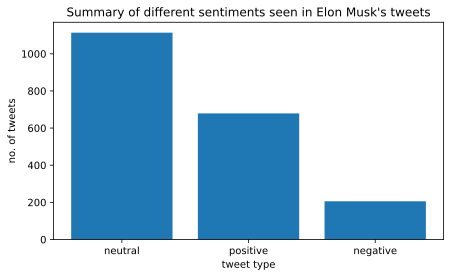

In [28]:
plt.bar(summary_vdr['tweeet_type'],summary_vdr['no_of_tweets'])
plt.xlabel('tweet type')
plt.ylabel('no. of tweets')
plt.title('Summary of different sentiments seen in Elon Musk\'s tweets')
plt.show()

### Line chart for visualizing the degree of positivity or negativity values.

In [29]:
# Function to plot line chart.
def tweet_vis(df, inc, step, labels):
    num_rows = df.shape[0]
    start_ind = inc
    num_pts = start_ind + step
    plt.figure(figsize = (25,4))
    plt.plot(range(num_rows)[start_ind:num_pts], df[labels[0]][start_ind:num_pts], 'g--', label = labels[0], alpha =0.9)
    plt.plot(range(num_rows)[start_ind:num_pts], df[labels[1]][start_ind:num_pts], 'r--', label = labels[1], alpha =0.9)
    plt.plot(range(num_rows)[start_ind:num_pts], df[labels[2]][start_ind:num_pts], 'm-', label = labels[2], alpha = 0.2)

    plt.xlabel('tweet no.')
    plt.ylabel('deg of positivity or negativity')
    plt.legend()
    plt.show()

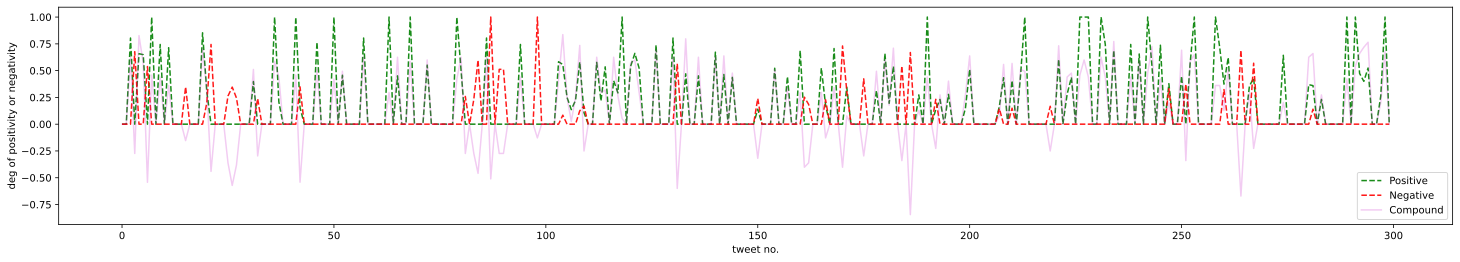

In [30]:
tweet_vis(df=tweets_prc, inc=0, step=300, labels=['Positive', 'Negative', 'Compound'])

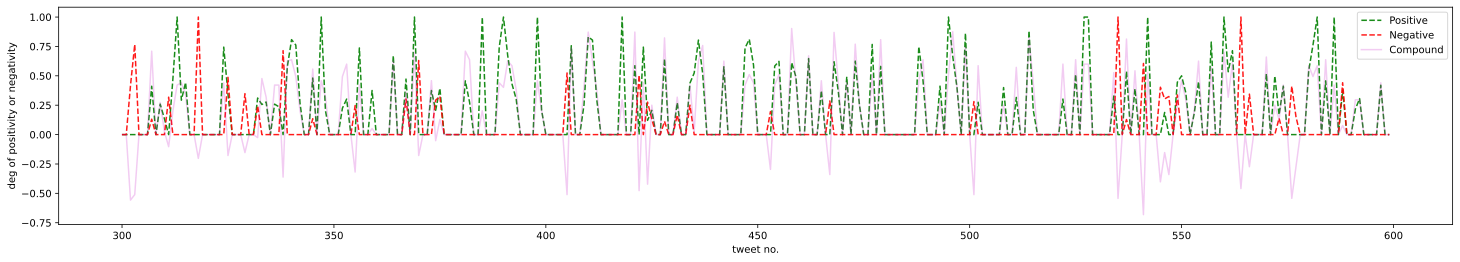

In [31]:
tweet_vis(df=tweets_prc, inc=300, step=300, labels=['Positive', 'Negative', 'Compound'])

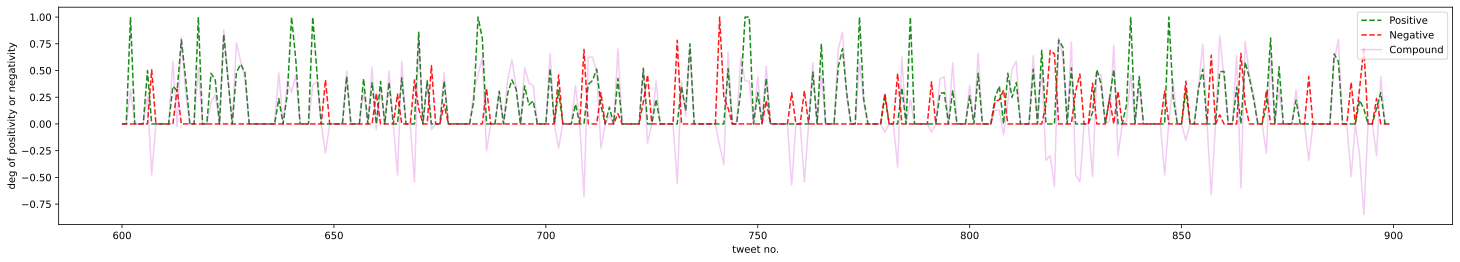

In [32]:
tweet_vis(df=tweets_prc, inc=600, step=300, labels=['Positive', 'Negative', 'Compound'])

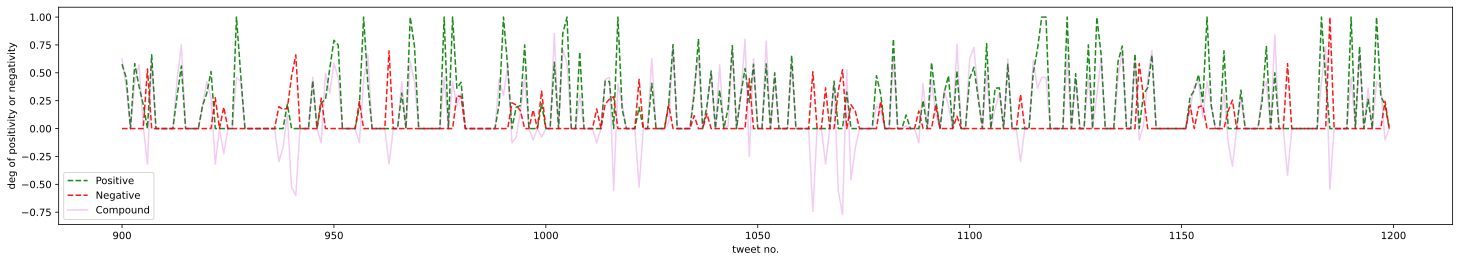

In [33]:
tweet_vis(df=tweets_prc, inc=900, step=300, labels=['Positive', 'Negative', 'Compound'])

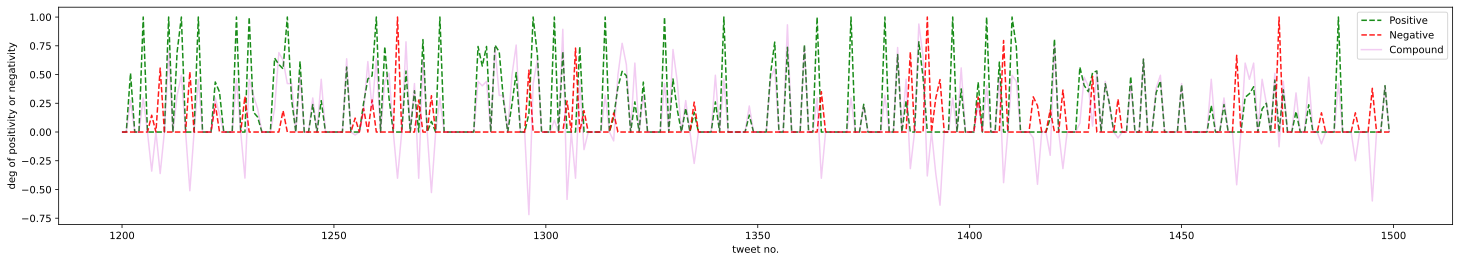

In [34]:
tweet_vis(df=tweets_prc, inc=1200, step=300, labels=['Positive', 'Negative', 'Compound'])

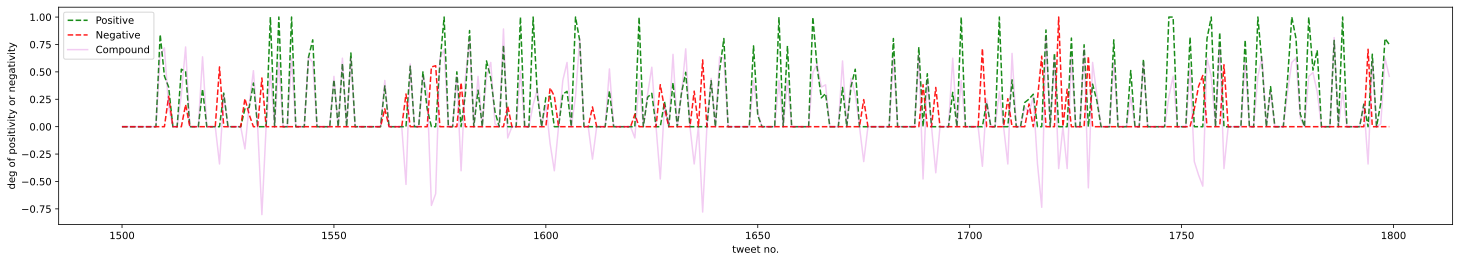

In [35]:
tweet_vis(df=tweets_prc, inc=1500, step=300, labels=['Positive', 'Negative', 'Compound'])

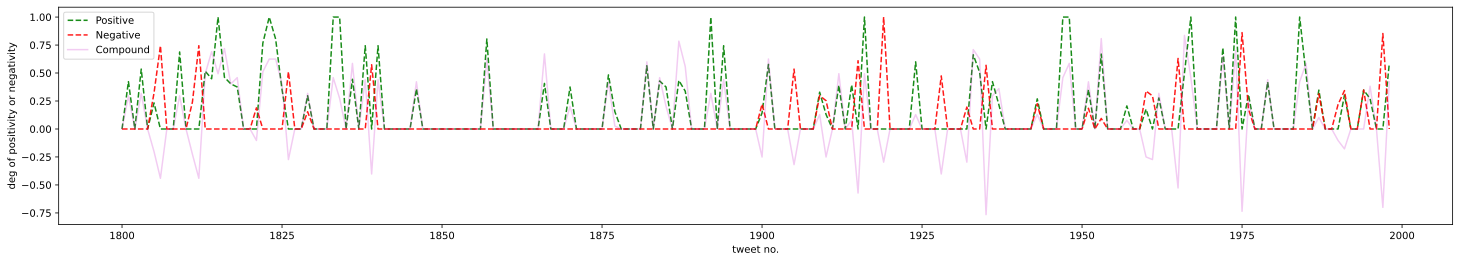

In [36]:
tweet_vis(df=tweets_prc, inc=1800, step=200, labels=['Positive', 'Negative', 'Compound'])

## Observations:
- Of the tweets that express emotion 679 tweets are positive, 206 are negative, 1114 are somewhat neutral.
- From the word maps it can be seen that most of his tweets focuses on work and appreciation and struggle.
- From the wordcloud made from all his words, we can see hope and optimisim. We can understand this from the words that are printed with a bigger size that mostly includes his projects like starship, his companies and his words of appreciation (possibly to his workers or colleagues).
- From the line charts, we can see the fluctuating nature of his emotions, dominated somewhat by positive sentiments overall.

## Conclusion:
Analysis of a fraction of tweets by Elon Musk was done, some visualizations were made and inferences were drawn with respect to words used, sentiment scores and overall sentiment observed in the tweets.